### Introduction
In this project we will create a model to analyze images of dogs and will output its guess of what breed it is.

We are using a dataset with 70 dog breeds with ~100 images per breed.

To create the model we used transfer learning with a variety of pretained models like: densenet, imagenet, ... then added new layers and fine tuning to make it work better for identifying dog breeds.

### Data Pre-Processing

We fortunately did not have to do any data pre-processing on our images.

They were already oganized into folder for each breed, there were train, test, and validation image sets along with the images already being the correct resolution for the DenseNet model.

### Model Setup

In [3]:
# Import all modules
import os
import tensorflow as tf
import keras
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.densenet import decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

import albumentations as A

import seaborn as sns

from itertools import cycle

In [4]:
# Get the pre-trained DenseNet model
model = tf.keras.applications.densenet.DenseNet121(
    include_top=True, weights='imagenet')

2024-04-22 13:52:44.622734: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 13:52:48.105743: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-04-22 13:52:48.107531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2024-04-22 13:52:48.109179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/rep

In [5]:
# Funtions to show the images, load and process them to the correct input shape and make a prediction
def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)
    
def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

def densenet_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

(224, 224, 3)


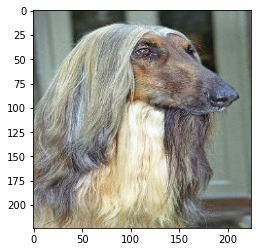

In [6]:
# Check that show_image works
show_image("test/Afghan/04.jpg")

In [7]:
processed_image = load_and_process_image("test/Afghan/04.jpg")

Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


2024-04-22 13:52:52.441642: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


Predicted: [[('n02085936', 'Maltese_dog', 0.83215106), ('n02098413', 'Lhasa', 0.084391564), ('n02098286', 'West_Highland_white_terrier', 0.018758198)]]


2024-04-22 13:52:54.645303: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


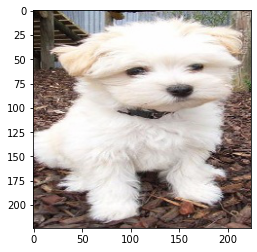

In [8]:
densenet_prediction("test/Maltese/04.jpg")

DenseNet is shown to already be pretty good at indentifying dog species, but we can make it better with more specialized higher layers.

### Training / Test / Validation Data Setup

In [10]:
# Get current working directory
current_dir = os.getcwd()

# Define the directories for training, validation, and testing data
train_dir = os.path.join(current_dir, 'train')
valid_dir = os.path.join(current_dir, 'valid')
test_dir = os.path.join(current_dir, 'test')

# Define the ImageDataGenerator for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    # Augmentation techniques
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the ImageDataGenerator for validation and testing data
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data generators for training, validation, and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # set as training data
)

validation_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 6390 images belonging to 70 classes.
Found 716 images belonging to 70 classes.
Found 702 images belonging to 70 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


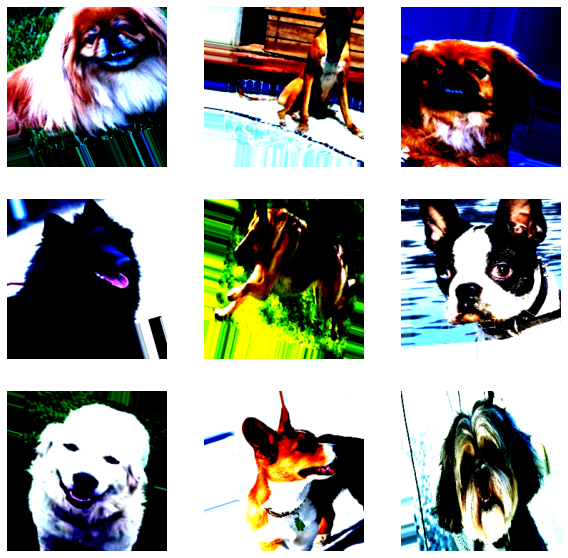

In [12]:
augmented_images, _ = train_generator.next()
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.show()

In [13]:
!pip install -U git+https://github.com/albumentations-team/albumentations

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/albumentations-team/albumentations to /scratch/local/29721639/pip-req-build-_m3lzt0x
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /scratch/local/29721639/pip-req-build-_m3lzt0x
  Resolved https://github.com/albumentations-team/albumentations to commit cc0d5a0c68f9c1d3e3262fd610e1d3bc9807e2fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


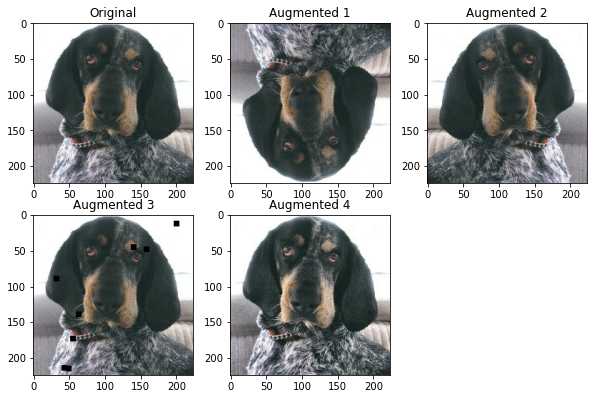

In [10]:
# Display augmented images
# Load the image
image_path = "test/Bluetick/04.jpg"  # Replace with the path to your image
image = image_utils.load_img(image_path, target_size=(224, 224))
image = image_utils.img_to_array(image)

# Define augmentation techniques
augments = [
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.CoarseDropout(p=1),
    A.CLAHE(p=1)
]

# Plot the original image and augmented images
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.title('Original')
plt.imshow(image.astype(np.uint8))

# Apply each augmentation technique and plot the augmented image
for i, augment in enumerate(augments):
    augmented_img = augment(image=image.astype(np.uint8))['image']  # Ensure the image is uint8
    plt.subplot(3, 3, i + 2)
    plt.title(f'Augmented {i + 1}')
    plt.imshow(augmented_img.astype(np.uint8))
plt.show()

### Creating Model and Hyperparameter Tuning

In [15]:
# Number of dog species to identify
num_classes = 70

# Define the base model (DenseNet121) without the top classification layer
base_model = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)

# Freeze the pre-trained layers
base_model.trainable = False

# Add a custom classification head
global_average_layer = GlobalAveragePooling2D()(base_model.output)
output_layer = Dense(num_classes, activation='softmax')(global_average_layer)

# Combine the base model with the new higher layers
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, batch_size=32, epochs=5, verbose=1, validation_data=validation_generator)

test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/5
200/200 [==============================] - 63s 299ms/step - loss: 1.7944 - accuracy: 0.6138 - val_loss: 0.7354 - val_accuracy: 0.8757
Epoch 2/5
200/200 [==============================] - 58s 287ms/step - loss: 0.5178 - accuracy: 0.8789 - val_loss: 0.5981 - val_accuracy: 0.8925
Epoch 3/5
200/200 [==============================] - 58s 289ms/step - loss: 0.3678 - accuracy: 0.9019 - val_loss: 0.5661 - val_accuracy: 0.9078
Epoch 4/5
200/200 [==============================] - 58s 288ms/step - loss: 0.3042 - accuracy: 0.9182 - val_loss: 0.5526 - val_accuracy: 0.9190
Epoch 5/5
22/22 [==============================] - 2s 101ms/step - loss: 0.1355 - accuracy: 0.9644
Test Loss: 0.1354997754096985
Test Accuracy: 0.9643874764442444


In [16]:
# Unfreeze the lower layers
model.trainable = True

# Compile the model with a lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Run the model for more epochs
history = model.fit(train_generator, batch_size=32, epochs=10, verbose=1, validation_data=validation_generator)

test_loss, test_accuracy = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
200/200 [==============================] - 65s 289ms/step - loss: 0.0132 - accuracy: 0.9019 - val_loss: 0.0134 - val_accuracy: 0.9134
Epoch 2/10
200/200 [==============================] - 58s 290ms/step - loss: 0.0088 - accuracy: 0.9397 - val_loss: 0.0124 - val_accuracy: 0.9218
Epoch 3/10
200/200 [==============================] - 56s 281ms/step - loss: 0.0068 - accuracy: 0.9557 - val_loss: 0.0115 - val_accuracy: 0.9218
Epoch 4/10
200/200 [==============================] - 56s 279ms/step - loss: 0.0055 - accuracy: 0.9687 - val_loss: 0.0115 - val_accuracy: 0.9260
Epoch 5/10
200/200 [==============================] - 58s 287ms/step - loss: 0.0045 - accuracy: 0.9750 - val_loss: 0.0119 - val_accuracy: 0.9092
Epoch 6/10
200/200 [==============================] - 56s 281ms/step - loss: 0.0039 - accuracy: 0.9790 - val_loss: 0.0122 - val_accuracy: 0.9190
Epoch 7/10
200/200 [==============================] - 56s 280ms/step - loss: 0.0032 - accuracy: 0.9861 - val_loss: 0.0130 - val_ac

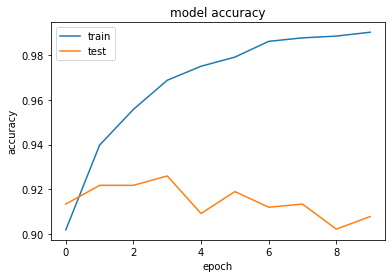

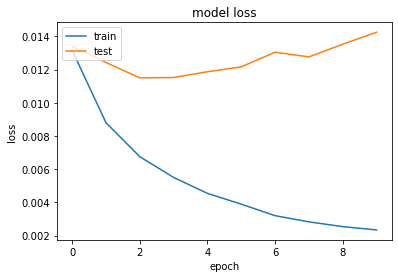

In [17]:
# Create a plot to show the change in model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Create a plot to show the change in loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(224, 224, 3)
Original image shape:  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Borzoi, Probability: 0.9999988079071045
Predicted class: Greyhound, Probability: 5.614289761979308e-07
Predicted class: Irish Wolfhound, Probability: 1.7531326079733844e-07


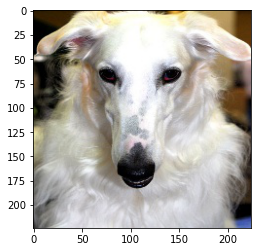

In [17]:
dog_species = [name for name in os.listdir('./test') if os.path.isdir(os.path.join('./test', name))]
dog_species.sort()

# Function to display the model's top predictions
def display_top_predictions(predictions, top=3):
    # Get the top predicted classes and corresponding probabilities
    top_indices = np.argsort(predictions)[0][-top:][::-1]
    top_probabilities = predictions[0][top_indices]
    
    # Print the top predictions
    for i in range(top):
        print(f"Predicted class: {dog_species[top_indices[i]]}, Probability: {top_probabilities[i]}")

# Function to use the model to predict an image and show the image
def model_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    #Display top predictions
    display_top_predictions(predictions)
    
model_prediction("valid/Borzoi/01.jpg")

Found 716 images belonging to 70 classes.


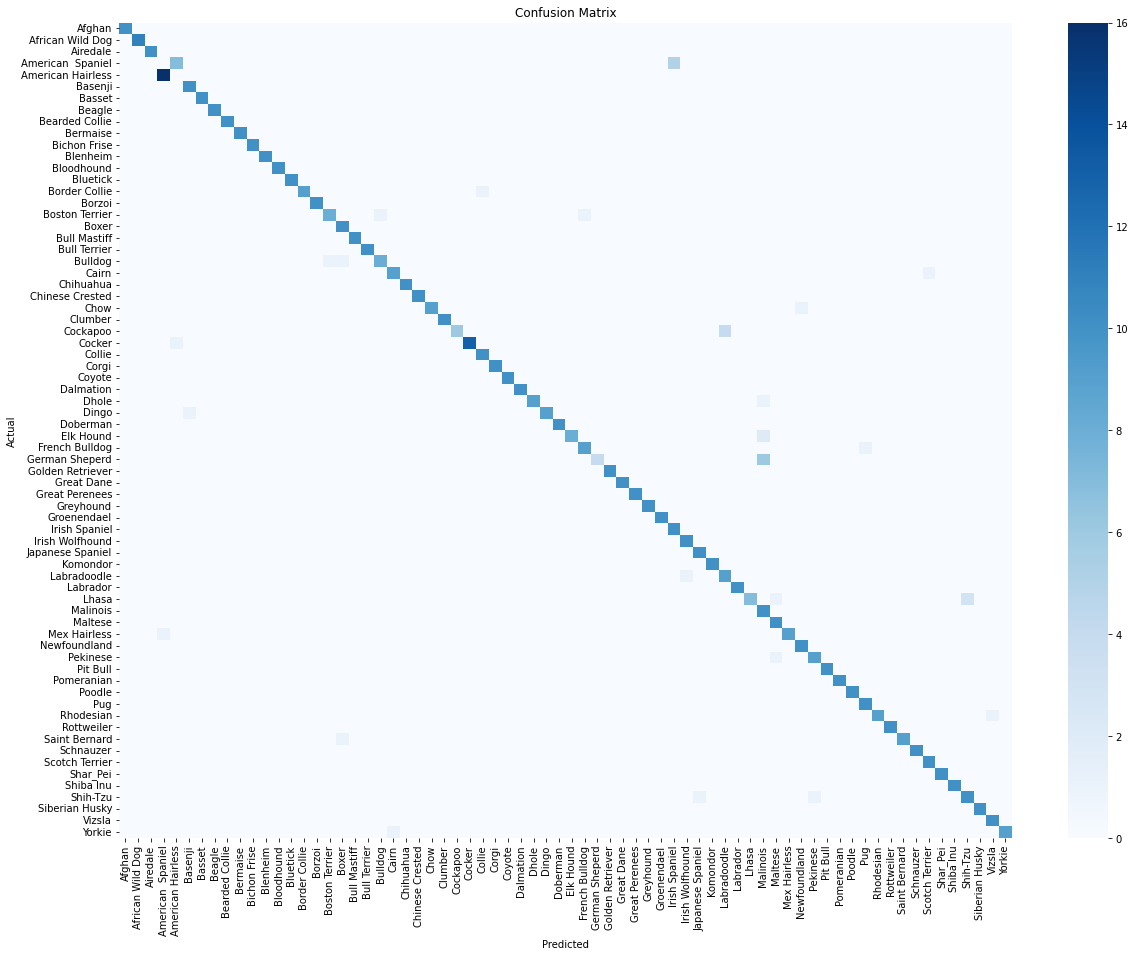

In [18]:
# Disable shuffling in the test generator
test_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Disable shuffling
)

# Predict classes for the test set
y_true = test_generator.classes

# Disable Dropout layers during inference
model.evaluate(test_generator, verbose=0)

# Predict classes for the test set again
y_pred = model.predict(test_generator).argmax(axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

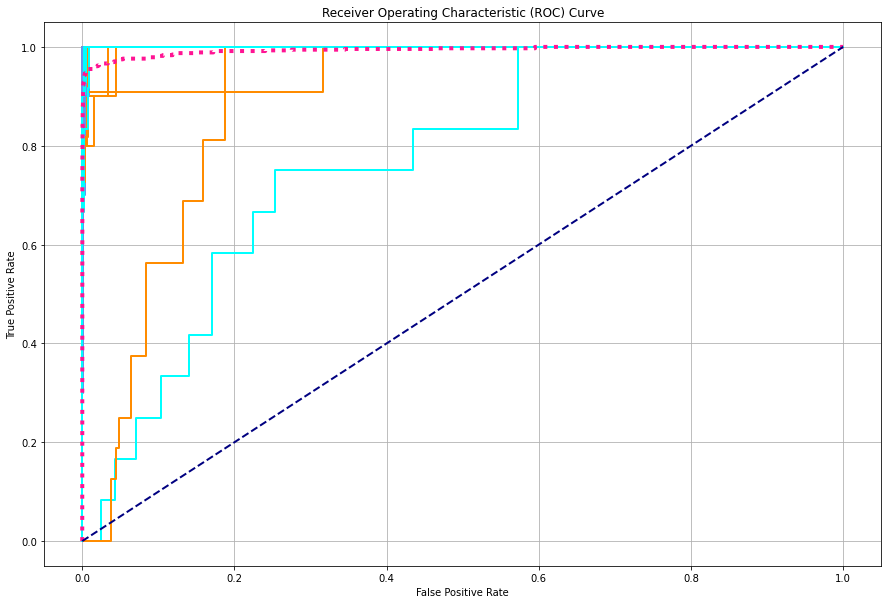

In [30]:
# Predict probabilities for each class for the test set
y_score = model.predict(test_generator)

# Binarize the true labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_true))):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class
plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(np.unique(y_true))), colors):        
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro,
         label='Micro-average ROC curve (AUC = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='deeppink', linestyle=':', linewidth=4)

# Plot random guessing line as comparison
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True)
plt.show()

### Results

- The final accuracy after fine tuning was determined to be 0.9701 with a loss of 0.0037
- These are very good values and means that our model achieved its goal of being able to accurately predict dog breeds based on inputted images
- The confusion matric and ROC Curve also reflect this conclusion.

In [18]:
model_prediction("irl/bald dog.jpg")

NameError: name 'model_prediction' is not defined

(736, 736, 3)
Original image shape:  (736, 736, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Corgi, Probability: 0.9992450475692749
Predicted class: German Sheperd, Probability: 0.0006869396311230958
Predicted class: Bulldog, Probability: 1.6990670701488853e-05


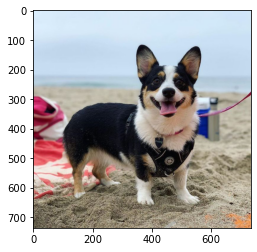

In [22]:
model_prediction("irl/corgihusky.jpg")

(525, 525, 3)
Original image shape:  (525, 525, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Labradoodle, Probability: 0.9685990214347839
Predicted class: Irish Wolfhound, Probability: 0.02505536563694477
Predicted class: Cairn, Probability: 0.0027844859287142754


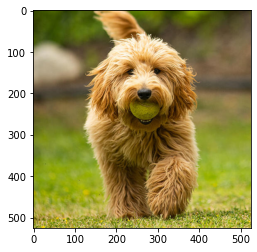

In [24]:
model_prediction("irl/Goldendoodle-image-2.jpg")

(1716, 1290, 3)
Original image shape:  (1716, 1290, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Cocker, Probability: 0.21876025199890137
Predicted class: Shih-Tzu, Probability: 0.1226440891623497
Predicted class: Coyote, Probability: 0.09361827373504639


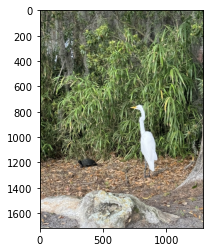

In [25]:
model_prediction("irl/nondogmodel_prediction("irl/Goldendoodle-image-2.jpg").jpg")

(720, 1280, 3)
Original image shape:  (720, 1280, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Dingo, Probability: 0.2725791037082672
Predicted class: Siberian Husky, Probability: 0.17680038511753082
Predicted class: Rhodesian, Probability: 0.09361542016267776


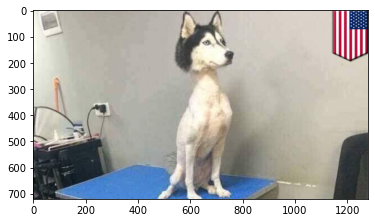

In [26]:
model_prediction("irl/shaved husky.jpg")

(952, 1290, 3)
Original image shape:  (952, 1290, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Chihuahua, Probability: 0.323534220457077
Predicted class: Shar_Pei, Probability: 0.27797919511795044
Predicted class: Rhodesian, Probability: 0.06230168044567108


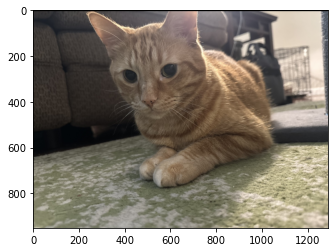

In [27]:
model_prediction("irl/cat1.jpg")

(1663, 1290, 3)
Original image shape:  (1663, 1290, 3)
Processed image shape:  (1, 224, 224, 3)
Predicted class: Shih-Tzu, Probability: 0.9999871253967285
Predicted class: Bulldog, Probability: 3.1185479656414827e-06
Predicted class: Pug, Probability: 2.571461664047092e-06


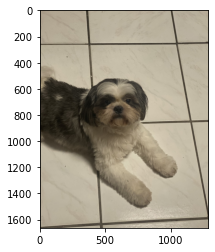

In [28]:
model_prediction("irl/dog2.jpg")

In [21]:
y_prob = model.predict(test_generator)

y_pred = np.argmax(y_prob, axis=1)

y_true = test_generator.classes

report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

print(report)

                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        11
         Airedale       1.00      1.00      1.00        10
American  Spaniel       0.00      0.00      0.00        12
American Hairless       0.00      0.00      0.00        16
          Basenji       0.91      1.00      0.95        10
           Basset       1.00      1.00      1.00        10
           Beagle       1.00      1.00      1.00        10
   Bearded Collie       1.00      1.00      1.00        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       1.00      1.00      1.00        10
         Blenheim       1.00      1.00      1.00        10
       Bloodhound       1.00      1.00      1.00        10
         Bluetick       1.00      1.00      1.00        10
    Border Collie       1.00      0.90      0.95        10
           Borzoi       1.00      1.00      1.00       

### Discussion

- It was difficult to generate the ROC curve and confusion matrix since we had to edit the data to be in the correct data structure.
- After they were generated, we found that the model gets confused between the American Hairless and American Spaniel
- The model also identifies the Shih Tzu as a Lhasa, which are very similar in appearance
- These weaknesses could be further improved on in future implementations of this algorithm. It could also be expanded to take in other dog breeds, and even whole other species all together.